In [9]:
# Library loading
%matplotlib inline

import pandas as pd # manipulate dataframes
import matplotlib.pyplot as plt # plotting
import matplotlib
import numpy as np
import torch, time

from sklearn.metrics import mean_squared_error
import h5py

import neuravi

# First we check if CUDA is available
print("CUDA AVAILABLE? ",torch.cuda.is_available())

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
      
device = torch.device('cpu') #get_default_device()
print(device)

CUDA AVAILABLE?  True
cpu


In [32]:
### Load dataset

path_data = "./data/DataSet_0p20val.hdf5"

path_raman = "./data/NKAS_Raman.hdf5"
path_density = "./data/NKAS_density.hdf5"

ds = neuravi.data_loader(path_data,path_raman,path_density,device)


/home/charles/anaconda3/envs/ml/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [34]:
# Declare model

neuralmodel = neuravi.model(4,300,7,ds.nb_channels_raman,p_drop=0.2) 
neuralmodel.load_state_dict(torch.load("./model/model.pth",map_location='cpu'))
neuralmodel.eval()

model(
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (linears): ModuleList(
    (0): Linear(in_features=4, out_features=300, bias=True)
    (1): Linear(in_features=300, out_features=300, bias=True)
    (2): Linear(in_features=300, out_features=300, bias=True)
    (3): Linear(in_features=300, out_features=300, bias=True)
    (4): Linear(in_features=300, out_features=300, bias=True)
    (5): Linear(in_features=300, out_features=300, bias=True)
    (6): Linear(in_features=300, out_features=300, bias=True)
  )
  (out_thermo): Linear(in_features=300, out_features=6, bias=True)
  (out_raman): Linear(in_features=300, out_features=850, bias=True)
)

AttributeError: module 'ternary' has no attribute 'TernaryAxesSubplot'

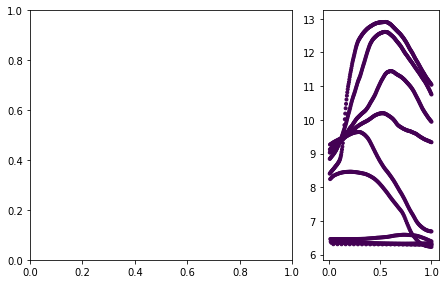

In [35]:
import math, ternary

#plt.figure(figsize=(3.22,5))

plt.subplot(1,3,3)


d_trig = []
colors_d_trig = []
for idx,nna in enumerate([0.25,0.225,0.20,0.175,0.15,0.125, 0.10, 0.075, 0.05, 0.025, 0.]):

    na2o = np.arange(0.,nna,0.001)
    k2o = nna-na2o
    sio2 = np.ones(len(na2o))*0.75
    al2o3 = 1-sio2-k2o-na2o

    d_trig.append((100-75-nna*100,75,nna*100))
    colors_d_trig.append(nna*4.)

    X_visu_ = np.vstack([sio2,al2o3,na2o,k2o]).T
    
    plt.scatter(X_visu_[:,3]/(X_visu_[:,2]+X_visu_[:,3]),
             neuralmodel.sctg(torch.Tensor(X_visu_).to(device)).cpu().detach().numpy(),
             marker='.',
             c=np.ones(X_visu_.shape[0])*nna*4,
                label="NN model")
    plt.draw()

    
plt.tight_layout()


ax = plt.subplot(1,3,(1,2))
tax = ternary.TernaryAxesSubplot(ax=ax,scale=100)
# figure.set_size_inches(6, 6)


tax.scatter(d_trig, c=colors_d_trig)
tax.boundary()
#tax.gridlines(color="black", multiple=6)
#tax.gridlines(color="blue", multiple=2, linewidth=0.5)

# Set Axis labels and Title
tax.left_corner_label("Na+K", fontsize=fontsize, offset=0.14)
tax.right_corner_label("Al", fontsize=fontsize, offset=0.14)
tax.top_corner_label("Si", fontsize=fontsize, offset=0.14)

# Remove default Matplotlib Axes
tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')
plt.tight_layout()

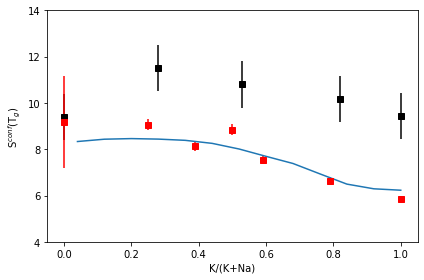

In [36]:
plt.xlabel("K/(K+Na)")
plt.ylabel("S$^{conf}$(T$_g$)")
plt.ylim(4,14)

plt.errorbar(np.array([0,0.28,0.53,0.82,1.0]),np.array([32.91,40.31,37.81,35.59,32.99])/7.0*2.0,
    yerr = 1.0, fmt="ks",
    label="Richet, 1984")

## endmember silicate
na2o = np.arange(0.,0.125,0.01)
k2o = 0.125-na2o
sio2 = np.ones(len(na2o))*0.75
al2o3 = np.ones(len(na2o))*0.125

X_visu_ = np.vstack([sio2,al2o3,na2o,k2o]).T
X_visu_.shape

plt.plot(X_visu_[:,3]/(X_visu_[:,2]+X_visu_[:,3]),neuralmodel.sctg(torch.Tensor(X_visu_).to(device)).cpu().detach().numpy(),label="NN model")

plt.xlabel("K/(K+Na)")
plt.ylabel("S$^{conf}$(T$_g$)")
plt.ylim(4,14)

plt.errorbar(np.array([0,0.25,0.39,0.50,0.59,0.79,1.00]),
             np.array([9.17,9.06,8.12,8.84,7.54,6.63,5.83]),
    yerr = np.array([2.,0.23,0.20,0.23,0.18,0.15,0.11]), fmt="s", color="r",
    label="Le Losq et al., 2017")

plt.tight_layout()

# Compare with Giordano

In [37]:
criterion = torch.nn.MSELoss()

neuralmodel.eval()
y_ag_train = neuralmodel.ag(ds.x_visco_train,ds.T_visco_train)
y_ag_valid = neuralmodel.ag(ds.x_visco_valid,ds.T_visco_valid)
y_ag_test = neuralmodel.ag(ds.x_visco_test,ds.T_visco_test)

y_myega_train = neuralmodel.myega(ds.x_visco_train,ds.T_visco_train)
y_myega_valid = neuralmodel.myega(ds.x_visco_valid,ds.T_visco_valid)
y_myega_test = neuralmodel.myega(ds.x_visco_test,ds.T_visco_test)

y_am_train = neuralmodel.am(ds.x_visco_train,ds.T_visco_train)
y_am_valid = neuralmodel.am(ds.x_visco_valid,ds.T_visco_valid)
y_am_test = neuralmodel.am(ds.x_visco_test,ds.T_visco_test)

ag_after_train = torch.sqrt(criterion(y_ag_train, ds.y_visco_train))
ag_after_valid = torch.sqrt(criterion(y_ag_valid, ds.y_visco_valid))
ag_after_test = torch.sqrt(criterion(y_ag_test, ds.y_visco_test))
print('AG train loss after training' , ag_after_train.item())
print('AG valid loss after training' , ag_after_valid.item())
print('AG test loss after training' , ag_after_test.item())
print('')
myega_after_train = torch.sqrt(criterion(y_myega_train, ds.y_visco_train))
myega_after_valid = torch.sqrt(criterion(y_myega_valid, ds.y_visco_valid))
myega_after_test = torch.sqrt(criterion(y_myega_test, ds.y_visco_test))
print('MYEGA train loss after training' , myega_after_train.item())
print('MYEGA valid loss after training' , myega_after_valid.item())
print('MYEGA test loss after training' , myega_after_test.item())
print('')
am_after_train = torch.sqrt(criterion(y_am_train, ds.y_visco_train))
am_after_valid = torch.sqrt(criterion(y_am_valid, ds.y_visco_valid))
am_after_test = torch.sqrt(criterion(y_am_test, ds.y_visco_test))
print('am train loss after training' , am_after_train.item())
print('am valid loss after training' , am_after_valid.item())
print('am test loss after training' , am_after_test.item())

AG train loss after training 0.3213289678096771
AG valid loss after training 0.645850419998169
AG test loss after training 0.6965101957321167

MYEGA train loss after training 0.34483104944229126
MYEGA valid loss after training 0.6996828317642212
MYEGA test loss after training 0.7299581170082092

am train loss after training 0.296177476644516
am valid loss after training 0.6582483053207397
am test loss after training 0.7065883278846741


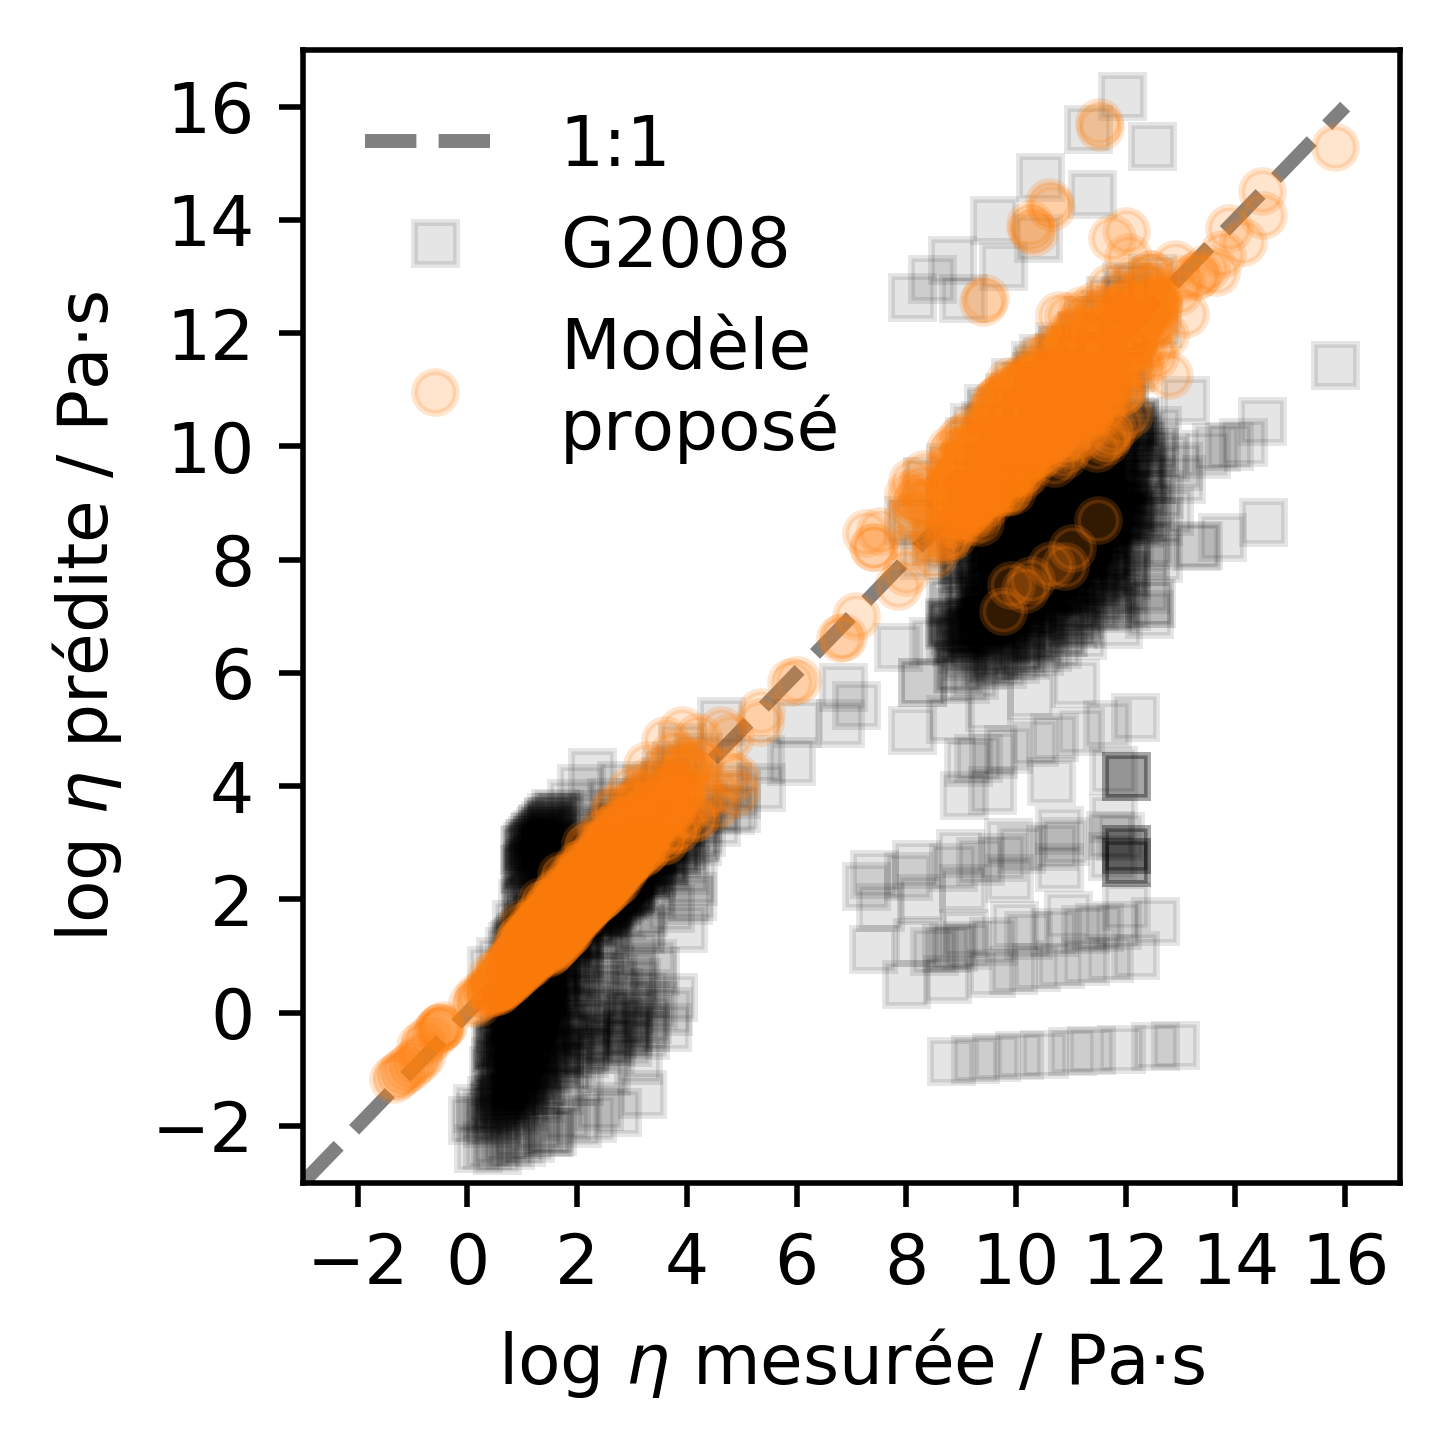

In [38]:
import sys
sys.path.append("../structupy")
sys.path.append("../viscopy")
import structupy as spy
import viscopy as vp

datas_ = pd.read_excel("./data/Database_IPGP.xlsx",sheet_name="Sheet1")
datas_ = spy.chimie_control(datas_)
Gmodel = vp.G2008(datas_)

plt.figure(figsize=(3.,3.),dpi=500)

plt.plot([-3,16],[-3,16],"--",color="grey",linewidth=2,label="1:1")

plt.plot(datas_.viscosity,Gmodel[0],"ks",alpha=0.1,label="G2008")

plt.xticks([-2,0,2,4,6,8,10,12,14,16])
plt.yticks([-2,0,2,4,6,8,10,12,14,16])

plt.xlim(-3,17)
plt.ylim(-3,17)

plt.ylabel("log $\eta$ prédite / Pa$\cdot$s")
plt.xlabel("log $\eta$ mesurée / Pa$\cdot$s")

plt.legend(frameon=False)
plt.tight_layout()
plt.savefig("./figures/Comp_G2008.png")

plt.plot(ds.y_visco_train.cpu().detach().numpy(),y_ag_train.cpu().detach().numpy(),"o",color="C1",alpha=0.2,label="Modèle\nproposé")
plt.plot(ds.y_visco_valid.cpu().detach().numpy(),y_ag_valid.cpu().detach().numpy(),"o",color="C1",alpha=0.2)
plt.plot(ds.y_visco_test.cpu().detach().numpy(),y_ag_test.cpu().detach().numpy(),"o",color="C1",alpha=0.2)
plt.legend(frameon=False)
plt.savefig("./figures/Comp_G2008_LL.png")


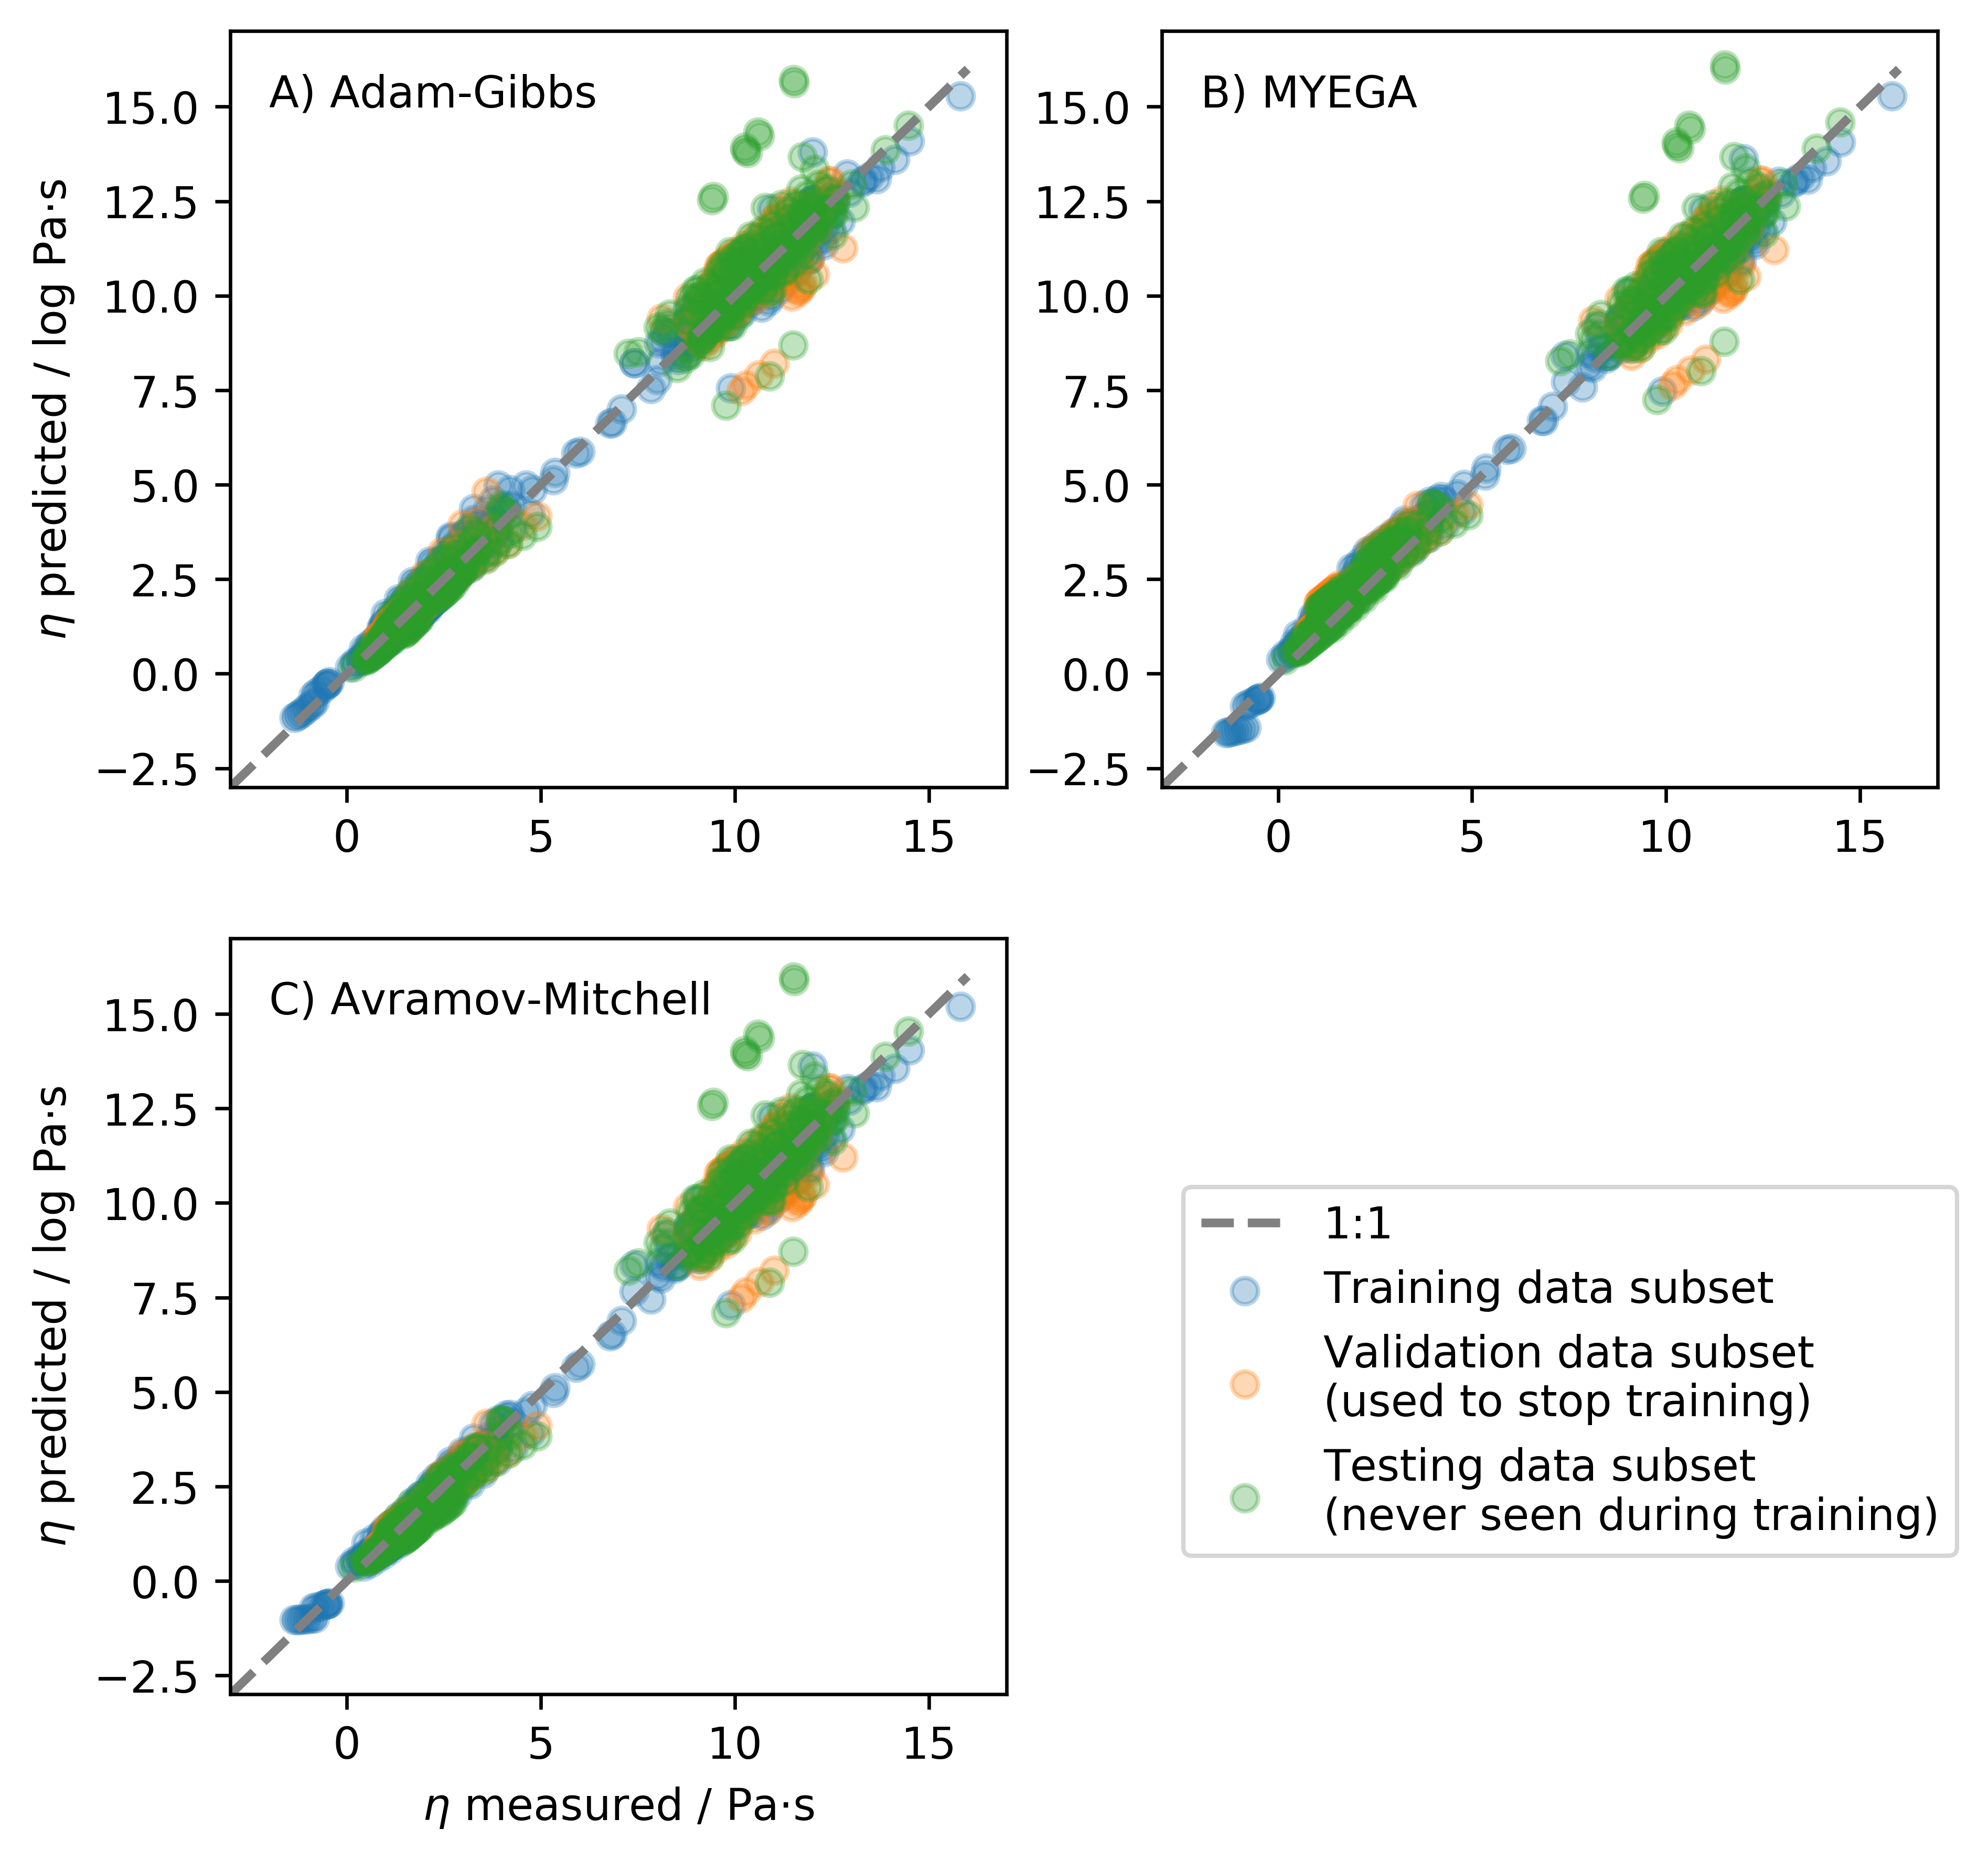

In [39]:
plt.figure(figsize=(7,7),dpi=600)

plt.subplot(2,2,1)
plt.scatter(ds.y_visco_train.cpu().detach().numpy(),y_ag_train.cpu().detach().numpy(),alpha=0.3,label="Train")
plt.scatter(ds.y_visco_valid.cpu().detach().numpy(),y_ag_valid.cpu().detach().numpy(),alpha=0.3,label="Valid")
plt.scatter(ds.y_visco_test.cpu().detach().numpy(),y_ag_test.cpu().detach().numpy(),alpha=0.3,label="Test")

plt.plot([-3,16],[-3,16],"--",color="grey",linewidth=2)

plt.xlim(-3,17)
plt.ylim(-3,17)

plt.ylabel("$\eta$ predicted / log Pa$\cdot$s")

plt.annotate("A) Adam-Gibbs",xy=(0.05,0.9),xycoords="axes fraction",ha="left")

#plt.legend(loc=4)

plt.subplot(2,2,2)
plt.scatter(ds.y_visco_train.cpu().detach().numpy(),y_myega_train.cpu().detach().numpy(),alpha=0.3,label="Train")
plt.scatter(ds.y_visco_valid.cpu().detach().numpy(),y_myega_valid.cpu().detach().numpy(),alpha=0.3,label="Valid")
plt.scatter(ds.y_visco_test.cpu().detach().numpy(),y_myega_test.cpu().detach().numpy(),alpha=0.3,label="Test")

plt.plot([-3,16],[-3,16],"--",color="grey",linewidth=2,label="1:1")

plt.xlim(-3,17)
plt.ylim(-3,17)

plt.annotate("B) MYEGA",xy=(0.05,0.9),xycoords="axes fraction",ha="left")

plt.subplot(2,2,3)
plt.scatter(ds.y_visco_train.cpu().detach().numpy(),y_am_train.cpu().detach().numpy(),alpha=0.3,label="Training data subset")
plt.scatter(ds.y_visco_valid.cpu().detach().numpy(),y_am_valid.cpu().detach().numpy(),alpha=0.3,label="Validation data subset\n(used to stop training)")
plt.scatter(ds.y_visco_test.cpu().detach().numpy(),y_am_test.cpu().detach().numpy(),alpha=0.3,label="Testing data subset\n(never seen during training)")

plt.plot([-3,16],[-3,16],"--",color="grey",linewidth=2,label="1:1")

plt.xlim(-3,17)
plt.ylim(-3,17)
plt.xlabel("$\eta$ measured / Pa$\cdot$s")
plt.ylabel("$\eta$ predicted / log Pa$\cdot$s")
plt.annotate("C) Avramov-Mitchell ",xy=(0.05,0.9),xycoords="axes fraction",ha="left")

plt.legend(bbox_to_anchor=(1.2, 0.7))

plt.xlabel("$\eta$ measured / Pa$\cdot$s")

#plt.tight_layout()
plt.savefig("./figures/Viscosity_models.png")

Checking shape...
(50, 4)


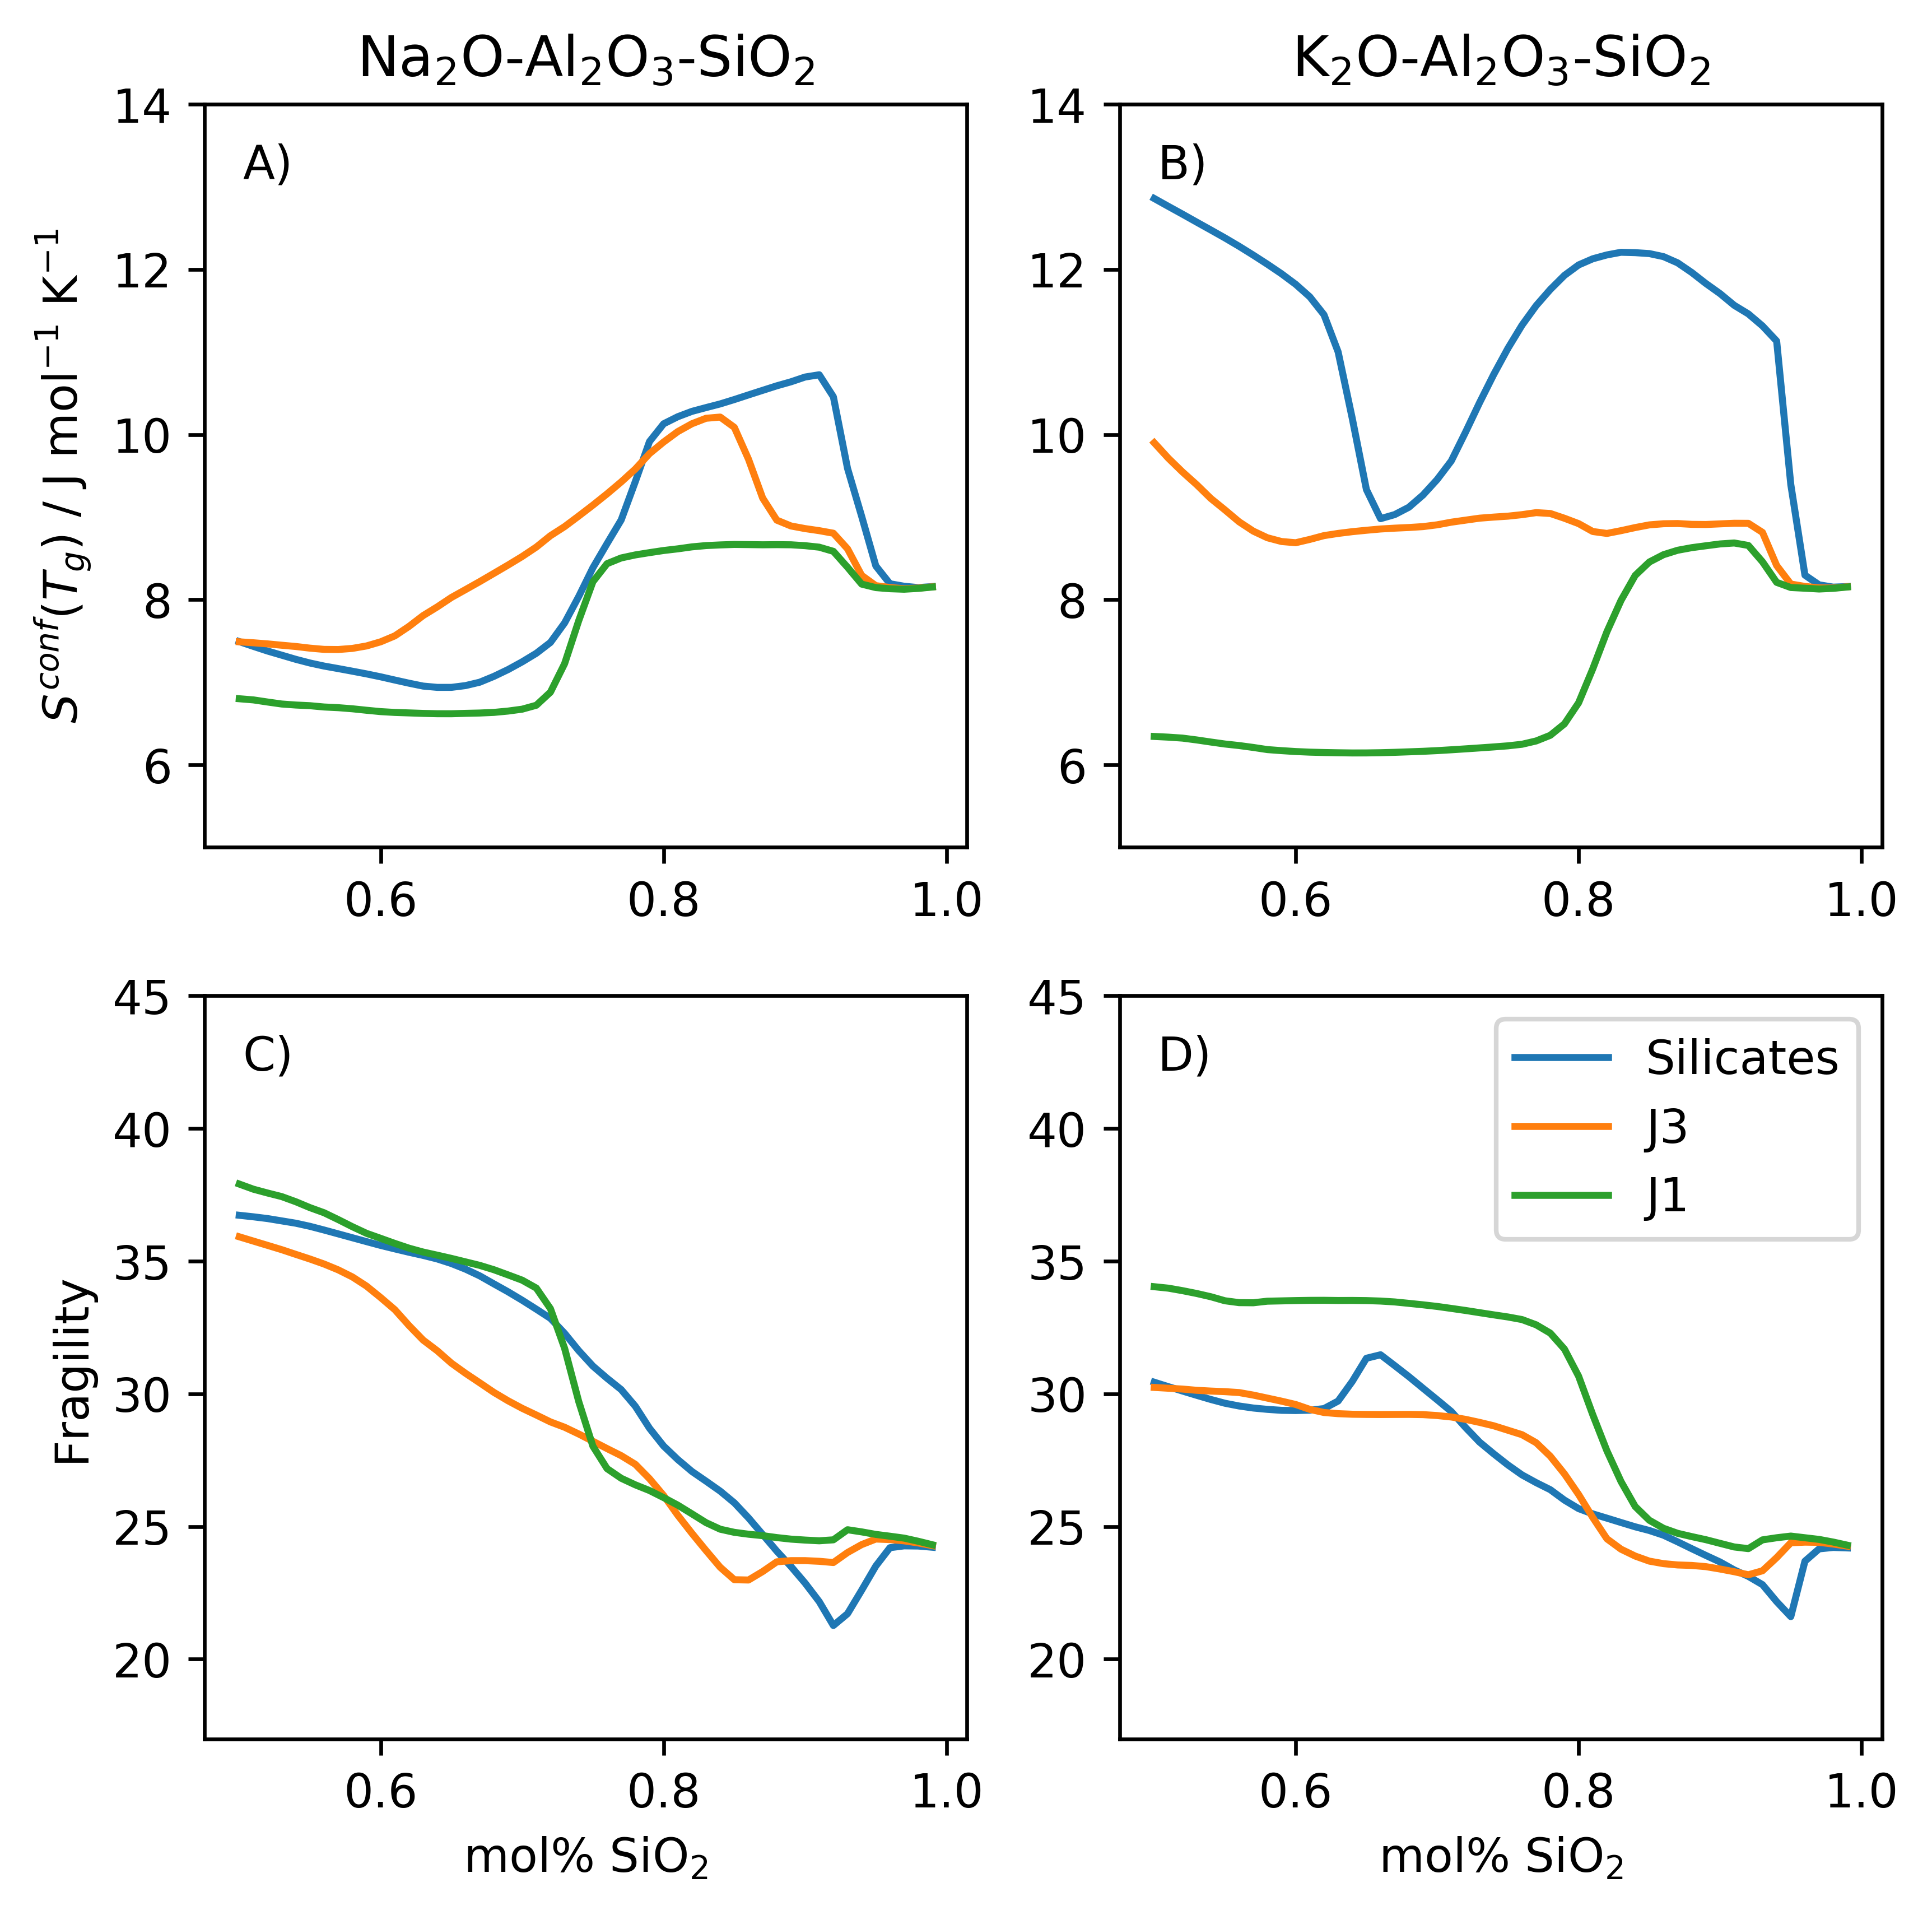

In [40]:
sio2 = np.arange(0.5,1.,0.01)

# order => sio2 al2o3 na2o k2o
X_visu_NAS_sili = np.vstack([sio2,np.zeros(len(sio2)),1.0-sio2,np.zeros(len(sio2))]).T
X_visu_NAS_J3 = np.vstack([sio2,(1.0-sio2)*1.0/3.0, (1.0-sio2)*2.0/3.0,np.zeros(len(sio2))]).T
X_visu_NAS_J1 = np.vstack([sio2,(1.0-sio2)*0.5, (1.0-sio2)*0.5,np.zeros(len(sio2))]).T

X_visu_KAS_sili = np.vstack([sio2,np.zeros(len(sio2)),np.zeros(len(sio2)),1.0-sio2]).T
X_visu_KAS_J3 = np.vstack([sio2,(1.0-sio2)*1.0/3.0,np.zeros(len(sio2)), (1.0-sio2)*2.0/3.0]).T
X_visu_KAS_J1 = np.vstack([sio2,(1.0-sio2)*0.5,np.zeros(len(sio2)), (1.0-sio2)*0.5]).T

Sctg_NAS_sili = neuralmodel.sctg(torch.Tensor(X_visu_NAS_sili).to(device)).cpu().detach().numpy()
Sctg_NAS_J3 = neuralmodel.sctg(torch.Tensor(X_visu_NAS_J3).to(device)).cpu().detach().numpy()
Sctg_NAS_J1 = neuralmodel.sctg(torch.Tensor(X_visu_NAS_J1).to(device)).cpu().detach().numpy()

Sctg_KAS_sili = neuralmodel.sctg(torch.Tensor(X_visu_KAS_sili).to(device)).cpu().detach().numpy()
Sctg_KAS_J3 = neuralmodel.sctg(torch.Tensor(X_visu_KAS_J3).to(device)).cpu().detach().numpy()
Sctg_KAS_J1 = neuralmodel.sctg(torch.Tensor(X_visu_KAS_J1).to(device)).cpu().detach().numpy()

tg_NAS_sili = neuralmodel.tg(torch.Tensor(X_visu_NAS_sili).to(device)).cpu().detach().numpy()
tg_NAS_J3 = neuralmodel.tg(torch.Tensor(X_visu_NAS_J3).to(device)).cpu().detach().numpy()
tg_NAS_J1 = neuralmodel.tg(torch.Tensor(X_visu_NAS_J1).to(device)).cpu().detach().numpy()

tg_KAS_sili = neuralmodel.tg(torch.Tensor(X_visu_KAS_sili).to(device)).cpu().detach().numpy()
tg_KAS_J3 = neuralmodel.tg(torch.Tensor(X_visu_KAS_J3).to(device)).cpu().detach().numpy()
tg_KAS_J1 = neuralmodel.tg(torch.Tensor(X_visu_KAS_J1).to(device)).cpu().detach().numpy()

m_NAS_sili = neuralmodel.fragility(torch.Tensor(X_visu_NAS_sili).to(device)).cpu().detach().numpy()
m_NAS_J3 = neuralmodel.fragility(torch.Tensor(X_visu_NAS_J3).to(device)).cpu().detach().numpy()
m_NAS_J1 = neuralmodel.fragility(torch.Tensor(X_visu_NAS_J1).to(device)).cpu().detach().numpy()

m_KAS_sili = neuralmodel.fragility(torch.Tensor(X_visu_KAS_sili).to(device)).cpu().detach().numpy()
m_KAS_J3 = neuralmodel.fragility(torch.Tensor(X_visu_KAS_J3).to(device)).cpu().detach().numpy()
m_KAS_J1 = neuralmodel.fragility(torch.Tensor(X_visu_KAS_J1).to(device)).cpu().detach().numpy()

print("Checking shape...")
print(X_visu_KAS_J1.shape)

plt.figure(figsize=(6.44,6.44), dpi=600)

plt.subplot(2,2,1) # NAS entropy

plt.plot(X_visu_NAS_sili[:,0],Sctg_NAS_sili,color="C0",label="Silicates")
plt.plot(X_visu_NAS_J3[:,0],Sctg_NAS_J3,color="C1",label="J3")
plt.plot(X_visu_NAS_J1[:,0],Sctg_NAS_J1,color="C2",label="J1")

plt.title(r"Na$_2$O-Al$_2$O$_3$-SiO$_2$")
plt.ylabel("$S^{conf}(T_g)$ / J mol$^{-1}$ K$^{-1}$")
plt.annotate("A)",xy=(0.05,0.9),xycoords="axes fraction",ha="left")
plt.ylim(5,14)

plt.subplot(2,2,2) # KAS entropy

plt.plot(X_visu_KAS_sili[:,0],Sctg_KAS_sili,color="C0",label="Silicates")
plt.plot(X_visu_KAS_J3[:,0],Sctg_KAS_J3,color="C1",label="J3")
plt.plot(X_visu_KAS_J1[:,0],Sctg_KAS_J1,color="C2",label="J1")

plt.title(r"K$_2$O-Al$_2$O$_3$-SiO$_2$")
plt.annotate("B)",xy=(0.05,0.9),xycoords="axes fraction",ha="left")
plt.ylim(5,14)

plt.subplot(2,2,3) # NAS fragility

plt.plot(X_visu_NAS_sili[:,0],m_NAS_sili,color="C0",label="Silicates")
plt.plot(X_visu_NAS_J3[:,0],m_NAS_J3,color="C1",label="J3")
plt.plot(X_visu_NAS_J1[:,0],m_NAS_J1,color="C2",label="J1")

plt.xlabel("mol% SiO$_2$")
plt.ylabel("Fragility")
plt.annotate("C)",xy=(0.05,0.9),xycoords="axes fraction",ha="left")
plt.ylim(17,45)

plt.subplot(2,2,4) # KAS fragility

plt.plot(X_visu_KAS_sili[:,0],m_KAS_sili,color="C0",label="Silicates")
plt.plot(X_visu_KAS_J3[:,0],m_KAS_J3,color="C1",label="J3")
plt.plot(X_visu_KAS_J1[:,0],m_KAS_J1,color="C2",label="J1")
plt.ylim(17,45)

plt.xlabel("mol% SiO$_2$")
plt.annotate("D)",xy=(0.05,0.9),xycoords="axes fraction",ha="left")

plt.legend(loc="upper right")

plt.savefig("./figures/Entropy_J_KNAS.png")

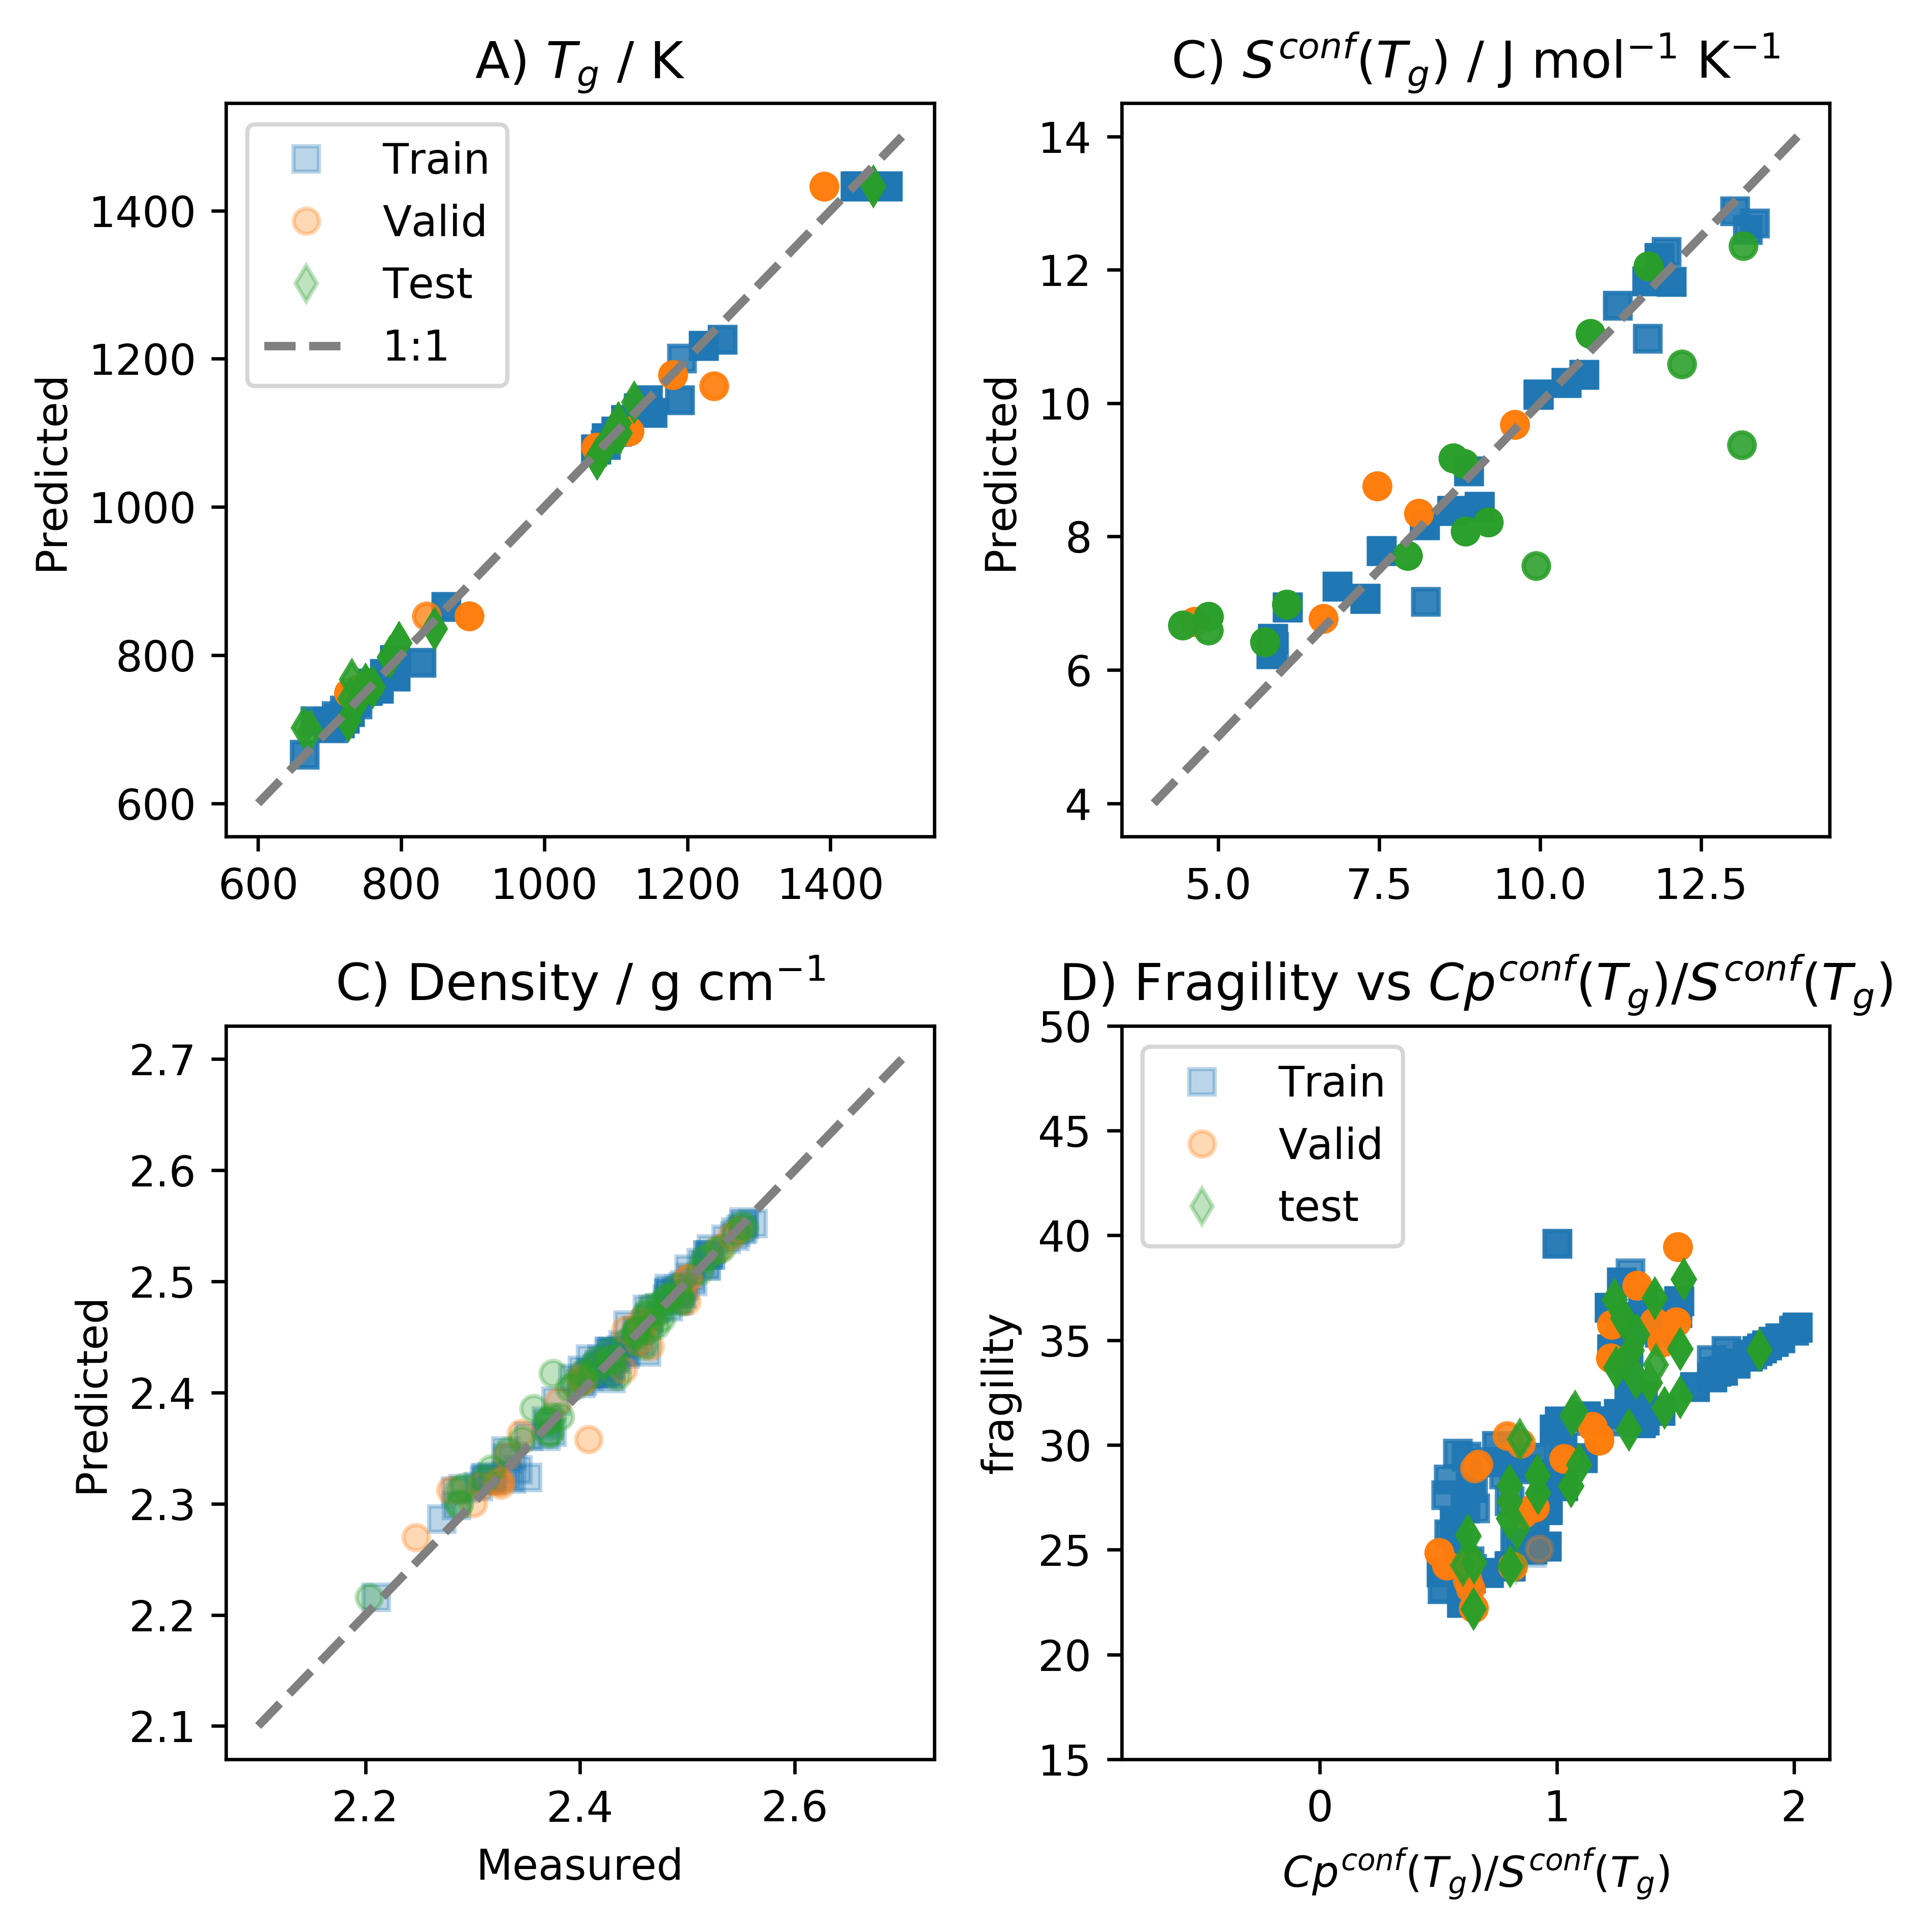

In [41]:
plt.figure(figsize=(6.44,6.44),dpi=600)

plt.subplot(2,2,1)
plt.plot(ds.y_tg_train.cpu().detach().numpy(),neuralmodel.tg(ds.x_tg_train).cpu().detach().numpy(),marker="s",linestyle="none",color="C0",alpha=0.3,label="Train")
plt.plot(ds.y_tg_valid.cpu().detach().numpy(),neuralmodel.tg(ds.x_tg_valid).cpu().detach().numpy(),"o",color="C1",alpha=0.3,label="Valid")
plt.plot(ds.y_tg_test.cpu().detach().numpy(),neuralmodel.tg(ds.x_tg_test).cpu().detach().numpy(),"d",color="C2",alpha=0.3,label="Test")

plt.ylabel("Predicted")
plt.title(r"A) $T_g$ / K")

plt.plot([600,1500],[600,1500],"--",color="grey",linewidth=2,label="1:1")

plt.legend(loc="upper left")

plt.subplot(2,2,2)
plt.plot(ds.y_entro_train.cpu().detach().numpy(),neuralmodel.sctg(ds.x_entro_train).cpu().detach().numpy(),"s",color="C0",alpha=0.3,label="Train")
plt.plot(ds.y_entro_valid.cpu().detach().numpy(),neuralmodel.sctg(ds.x_entro_valid).cpu().detach().numpy(),"o",color="C1",alpha=0.3,label="Valid")
plt.plot(ds.y_entro_test.cpu().detach().numpy(),neuralmodel.sctg(ds.x_entro_test).cpu().detach().numpy(),"o",color="C2",alpha=0.3,label="Test")
plt.ylabel("Predicted")
plt.title(r"C) $S^{conf}(T_g)$ / J mol$^{-1}$ K$^{-1}$")

plt.plot([4,14],[4,14],"--",color="grey",linewidth=2,label="1:1")

plt.subplot(2,2,3)
plt.plot(ds.y_density_train.cpu().detach().numpy(),neuralmodel.density(ds.x_density_train).cpu().detach().numpy(),"s",color="C0",alpha=0.3,label="Train")
plt.plot(ds.y_density_valid.cpu().detach().numpy(),neuralmodel.density(ds.x_density_valid).cpu().detach().numpy(),"o",color="C1",alpha=0.3,label="Valid")
plt.plot(ds.y_density_test.cpu().detach().numpy(),neuralmodel.density(ds.x_density_test).cpu().detach().numpy(),"o",color="C2",alpha=0.3,label="Test")

plt.xlabel("Measured")
plt.ylabel("Predicted")
plt.title(r"C) Density / g cm$^{-1}$")

plt.plot([2.1,2.7],[2.1,2.7],"--",color="grey",linewidth=2,label="1:1")

plt.subplot(2,2,4)

# Train
Cpconf = neuralmodel.ap_calc(ds.x_visco_train) + neuralmodel.b_calc(ds.x_visco_train)* neuralmodel.tg(ds.x_visco_train)
Cp_S = Cpconf/neuralmodel.sctg(ds.x_visco_train)
plt.plot(Cp_S.cpu().detach().numpy(),
         neuralmodel.fragility(ds.x_visco_train).cpu().detach().numpy(),"s",color="C0",alpha=0.3,label="Train")

# Valid
Cpconf = neuralmodel.ap_calc(ds.x_visco_valid) + neuralmodel.b_calc(ds.x_visco_valid)* neuralmodel.tg(ds.x_visco_valid)
Cp_S = Cpconf/neuralmodel.sctg(ds.x_visco_valid)
plt.plot(Cp_S.cpu().detach().numpy(),
         neuralmodel.fragility(ds.x_visco_valid).cpu().detach().numpy(),"o",color="C1",alpha=0.3,label="Valid")

# Test
Cpconf = neuralmodel.ap_calc(ds.x_visco_test) + neuralmodel.b_calc(ds.x_visco_test)* neuralmodel.tg(ds.x_visco_test)
Cp_S = Cpconf/neuralmodel.sctg(ds.x_visco_test)
plt.plot(Cp_S.cpu().detach().numpy(),neuralmodel.fragility(ds.x_visco_test).cpu().detach().numpy(),"d",color="C2",alpha=0.3,label="test")

plt.xlabel(r"$Cp^{conf}(T_g)/S^{conf}(T_g)$")
plt.ylabel("fragility")

plt.title(r"D) Fragility vs $Cp^{conf}(T_g)/S^{conf}(T_g)$")

plt.ylim(15,50)

plt.legend()

plt.tight_layout()

plt.savefig("./figures/Pred_Mes_TgSDens.png")

# Raman figure

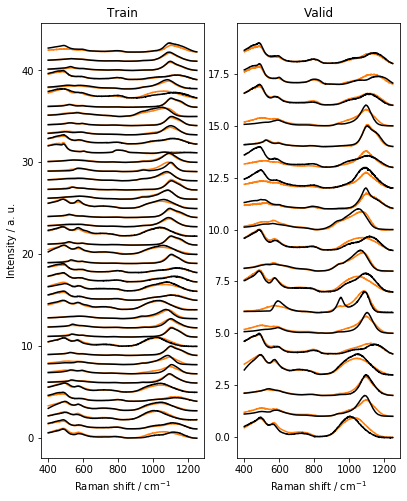

In [42]:
x_raman_shift = np.arange(400.,1250.,1.0) # our real x axis, for resampling

plt.figure(figsize=(6.44,8))

###
plt.subplot(1,2,1)
plt.title("Train")
Raman_error = 0.
shift = 0.
for i in range(ds.x_raman_train.shape[0]):
    Raman_error += np.sum((neuralmodel.raman_pred(ds.x_raman_train[i,:]).detach().numpy()-ds.y_raman_train[i,:].detach().numpy())**2)/np.sum(ds.y_raman_train[i,:].detach().numpy())
    plt.plot(x_raman_shift,neuralmodel.raman_pred(ds.x_raman_train[i,:]).detach().numpy()+shift,color="C1")
    plt.plot(x_raman_shift,ds.y_raman_train[i,:].detach().numpy()+shift,"k-")
    shift += 1.
plt.xlabel("Raman shift / cm$^{-1}$")
plt.ylabel("Intensity / a. u.")
Raman_error = Raman_error/ds.x_raman_train.shape[0]
###
plt.subplot(1,2,2)
plt.title("Valid")

shift = 0.
for i in range(ds.x_raman_valid.shape[0]):
    
    plt.plot(x_raman_shift,neuralmodel.raman_pred(ds.x_raman_valid[i,:]).detach().numpy()+shift,color="C1")
    plt.plot(x_raman_shift,ds.y_raman_valid[i,:].detach().numpy()+shift,"k-")
    shift += 1.

plt.xlabel("Raman shift / cm$^{-1}$")
plt.savefig("./figures/Raman_preds.pdf")

In [43]:
visu_KAS_Raman_sili = neuralmodel.raman_pred(torch.FloatTensor(X_visu_KAS_sili).to(device)).cpu().detach().numpy()
visu_KAS_Raman_J3 = neuralmodel.raman_pred(torch.FloatTensor(X_visu_KAS_J3).to(device)).cpu().detach().numpy()
visu_KAS_Raman_J1 = neuralmodel.raman_pred(torch.FloatTensor(X_visu_KAS_J1).to(device)).cpu().detach().numpy()

visu_NAS_Raman_sili = neuralmodel.raman_pred(torch.FloatTensor(X_visu_NAS_sili).to(device)).cpu().detach().numpy()
visu_NAS_Raman_J3 = neuralmodel.raman_pred(torch.FloatTensor(X_visu_NAS_J3).to(device)).cpu().detach().numpy()
visu_NAS_Raman_J1 = neuralmodel.raman_pred(torch.FloatTensor(X_visu_NAS_J1).to(device)).cpu().detach().numpy()

Rr_KAS_sili = np.trapz(visu_KAS_Raman_sili[:,x_raman_shift<670],x_raman_shift[x_raman_shift<670],axis=1)/np.trapz(visu_KAS_Raman_sili[:,x_raman_shift>800],x_raman_shift[x_raman_shift>800],axis=1)
Rr_KAS_J3 = np.trapz(visu_KAS_Raman_J3[:,x_raman_shift<670],x_raman_shift[x_raman_shift<670],axis=1)/np.trapz(visu_KAS_Raman_J3[:,x_raman_shift>800],x_raman_shift[x_raman_shift>800],axis=1)
Rr_KAS_J1 = np.trapz(visu_KAS_Raman_J1[:,x_raman_shift<670],x_raman_shift[x_raman_shift<670],axis=1)/np.trapz(visu_KAS_Raman_J1[:,x_raman_shift>800],x_raman_shift[x_raman_shift>800],axis=1)

Rr_NAS_sili = np.trapz(visu_NAS_Raman_sili[:,x_raman_shift<670],x_raman_shift[x_raman_shift<670],axis=1)/np.trapz(visu_NAS_Raman_sili[:,x_raman_shift>800],x_raman_shift[x_raman_shift>800],axis=1)
Rr_NAS_J3 = np.trapz(visu_NAS_Raman_J3[:,x_raman_shift<670],x_raman_shift[x_raman_shift<670],axis=1)/np.trapz(visu_NAS_Raman_J3[:,x_raman_shift>800],x_raman_shift[x_raman_shift>800],axis=1)
Rr_NAS_J1 = np.trapz(visu_NAS_Raman_J1[:,x_raman_shift<670],x_raman_shift[x_raman_shift<670],axis=1)/np.trapz(visu_NAS_Raman_J1[:,x_raman_shift>800],x_raman_shift[x_raman_shift>800],axis=1)




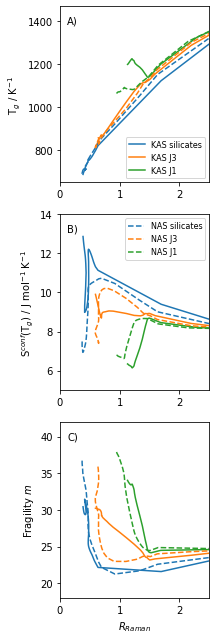

In [44]:
plt.figure(figsize=(3.22,9))

plt.subplot(3,1,1)
plt.plot(Rr_KAS_sili,tg_KAS_sili,color="C0",label="KAS silicates")
plt.plot(Rr_KAS_J3,tg_KAS_J3,color="C1",label="KAS J3")
plt.plot(Rr_KAS_J1,tg_KAS_J1,color="C2", label="KAS J1")

plt.plot(Rr_NAS_sili,tg_NAS_sili,"--",color="C0")
plt.plot(Rr_NAS_J3,tg_NAS_J3,"--",color="C1")
plt.plot(Rr_NAS_J1,tg_NAS_J1,"--",color="C2")
plt.legend(loc="lower right",fontsize=8)

plt.annotate("A)",xy=(0.05,0.9),xycoords="axes fraction",ha="left")

plt.xlim(0,2.5)
plt.ylabel(r"T$_{g}$ / K$^{-1}$")

plt.subplot(3,1,2)
plt.plot(Rr_KAS_sili,Sctg_KAS_sili,color="C0")
plt.plot(Rr_KAS_J3,Sctg_KAS_J3,color="C1")
plt.plot(Rr_KAS_J1,Sctg_KAS_J1,color="C2")

plt.plot(Rr_NAS_sili,Sctg_NAS_sili,"--",color="C0",label="NAS silicates")
plt.plot(Rr_NAS_J3,Sctg_NAS_J3,"--",color="C1",label="NAS J3")
plt.plot(Rr_NAS_J1,Sctg_NAS_J1,"--",color="C2",label="NAS J1")

plt.legend(loc="upper right",fontsize=8)

plt.xlim(0,2.5)
plt.ylabel(r"S$^{conf}$(T$_{g}$) / J mol$^{-1}$ K$^{-1}$")

plt.ylim(5,14)

plt.annotate("B)",xy=(0.05,0.9),xycoords="axes fraction",ha="left")

plt.subplot(3,1,3)
plt.plot(Rr_KAS_sili,m_KAS_sili,color="C0")
plt.plot(Rr_KAS_J3,m_KAS_J3,color="C1")
plt.plot(Rr_KAS_J1,m_KAS_J1,color="C2")

plt.plot(Rr_NAS_sili,m_NAS_sili,"--",color="C0")
plt.plot(Rr_NAS_J3,m_NAS_J3,"--",color="C1")
plt.plot(Rr_NAS_J1,m_NAS_J1,"--",color="C2")

plt.xlim(0,2.5)
plt.ylim(18,42)
plt.xlabel("$R_{Raman}$")
plt.ylabel(r"Fragility $m$")

#plt.ylim(5,14)

plt.annotate("C)",xy=(0.05,0.9),xycoords="axes fraction",ha="left")

plt.tight_layout()
plt.savefig("./figures/Raman_m_Tg.pdf")

In [46]:
Tecto_KAS = pd.DataFrame()
Tecto_KAS["sio2"] = np.arange(.6,0.8,0.01)
Tecto_KAS["al2o3"] = np.linspace(.2,0.1,num=len(Tecto_KAS.sio2))
Tecto_KAS["na2o"] = np.zeros(len(Tecto_KAS.sio2))
Tecto_KAS["k2o"] = np.linspace(.2,0.1,num=len(Tecto_KAS.sio2))
Tecto_KAS_Raman = neuralmodel.raman_pred(torch.FloatTensor(Tecto_KAS.values).to(device)).cpu().detach().numpy()
Tecto_KAS_sconf = neuralmodel.sctg(torch.FloatTensor(Tecto_KAS.values).to(device)).cpu().detach().numpy()
Tecto_KAS_tg = neuralmodel.tg(torch.FloatTensor(Tecto_KAS.values).to(device)).cpu().detach().numpy()
Tecto_KAS_tg = neuralmodel.tg(torch.FloatTensor(Tecto_KAS.values).to(device)).cpu().detach().numpy()
Tecto_KAS_Rr = np.trapz(Tecto_KAS_Raman[:,x_raman_shift<670],x_raman_shift[x_raman_shift<670],axis=1)/np.trapz(Tecto_KAS_Raman[:,x_raman_shift>800],x_raman_shift[x_raman_shift>800],axis=1)

Tecto_NAS = pd.DataFrame()
Tecto_NAS["sio2"] = np.arange(.6,0.8,0.01)
Tecto_NAS["al2o3"] = np.linspace(.2,0.1,num=len(Tecto_NAS.sio2))
Tecto_NAS["na2o"] = np.linspace(.2,0.1,num=len(Tecto_NAS.sio2)) 
Tecto_NAS["k2o"] = np.zeros(len(Tecto_NAS.sio2))
Tecto_NAS_Raman = neuralmodel.raman_pred(torch.FloatTensor(Tecto_NAS.values).to(device)).cpu().detach().numpy()
Tecto_NAS_sconf = neuralmodel.tg(torch.FloatTensor(Tecto_NAS.values).to(device)).cpu().detach().numpy()

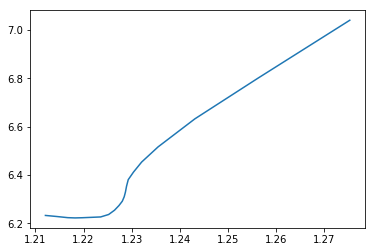

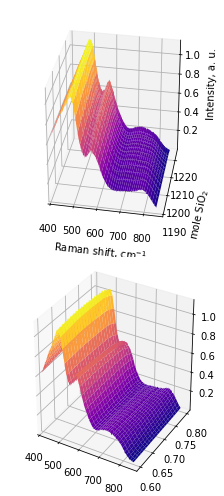

In [34]:
from mpl_toolkits.mplot3d import Axes3D

lb = 200
hb = 850

fig = plt.figure(figsize=(3.22,7))
ax_3d_1 = fig.add_subplot(211, projection='3d')
ax_3d_2 = fig.add_subplot(212, projection='3d')

ax_3d_1.plot_surface( (x_raman_shift.reshape(1,-1)*np.ones((21,850)))[:,(lb<x_raman_shift)&(x_raman_shift<hb)],
                     Tecto_KAS_sconf[:,0].reshape(-1,1)*np.ones((21,850))[:,(lb<x_raman_shift)&(x_raman_shift<hb)],
                     #(Tecto_KAS.values[:,0].reshape(-1,1)*np.ones((21,850)))[:,(lb<x_raman_shift)&(x_raman_shift<hb)], 
                     Tecto_KAS_Raman[:,(lb<x_raman_shift)&(x_raman_shift<hb)],
                     cmap="plasma")
ax_3d_1.set_xlim(400,)
ax_3d_1.view_init(30, -80)

ax_3d_1.set_xlabel("Raman shift, cm$^{-1}$")
ax_3d_1.set_ylabel("mole SiO$_2$",labelpad=10)
ax_3d_1.set_zlabel("Intensity, a. u.",labelpad=10)

ax_3d_2.plot_surface((x_raman_shift.reshape(1,-1)*np.ones((21,850)))[:,(lb<x_raman_shift)&(x_raman_shift<hb)], 
                  (Tecto_KAS.values[:,0].reshape(-1,1)*np.ones((21,850)))[:,(lb<x_raman_shift)&(x_raman_shift<hb)], 
                  Tecto_KAS_Raman[:,(lb<x_raman_shift)&(x_raman_shift<hb)],
               cmap="plasma")
ax_3d_2.set_xlim(400,)
ax_3d_2.view_init(30, -60)

plt.tight_layout()

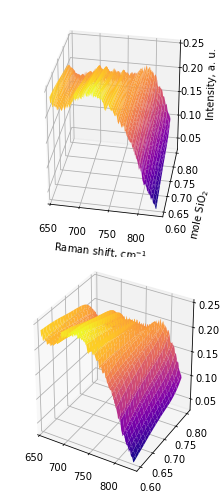

In [15]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(3.22,7))
ax_3d_1 = fig.add_subplot(211, projection='3d')
ax_3d_2 = fig.add_subplot(212, projection='3d')

ax_3d_1.plot_surface( (x_raman_shift.reshape(1,-1)*np.ones((21,850)))[:,(650<x_raman_shift)&(x_raman_shift<830)], 
                  (Tecto_KAS.values[:,0].reshape(-1,1)*np.ones((21,850)))[:,(650<x_raman_shift)&(x_raman_shift<830)], 
                  Tecto_KAS_Raman[:,(650<x_raman_shift)&(x_raman_shift<830)],
               cmap="plasma")
ax_3d_1.set_xlim(650,)
ax_3d_1.view_init(30, -80)

ax_3d_1.set_xlabel("Raman shift, cm$^{-1}$")
ax_3d_1.set_ylabel("mole SiO$_2$",labelpad=10)
ax_3d_1.set_zlabel("Intensity, a. u.",labelpad=10)

ax_3d_2.plot_surface((x_raman_shift.reshape(1,-1)*np.ones((21,850)))[:,(650<x_raman_shift)&(x_raman_shift<830)], 
                  (Tecto_KAS.values[:,0].reshape(-1,1)*np.ones((21,850)))[:,(650<x_raman_shift)&(x_raman_shift<830)], 
                  Tecto_KAS_Raman[:,(650<x_raman_shift)&(x_raman_shift<830)],
               cmap="plasma")
ax_3d_2.set_xlim(650,)
ax_3d_2.view_init(30, -60)

plt.tight_layout()

In [64]:
Tecto_KAS.values[:,0].reshape(-1,1)*np.ones((21,850))

array([[0.6 , 0.6 , 0.6 , ..., 0.6 , 0.6 , 0.6 ],
       [0.61, 0.61, 0.61, ..., 0.61, 0.61, 0.61],
       [0.62, 0.62, 0.62, ..., 0.62, 0.62, 0.62],
       ...,
       [0.78, 0.78, 0.78, ..., 0.78, 0.78, 0.78],
       [0.79, 0.79, 0.79, ..., 0.79, 0.79, 0.79],
       [0.8 , 0.8 , 0.8 , ..., 0.8 , 0.8 , 0.8 ]])

In [63]:
plt.tricontour(.ravel(),Tecto_KAS.values[:,0].reshape(-1,1)*np.ones((21,850)).ravel())

ValueError: operands could not be broadcast together with shapes (1,850) (17850,) 

# Density RMSE on test set

In [22]:
diff = mean_squared_error(ds.y_density_test.cpu().detach().numpy(),neuralmodel.density(ds.x_density_test).cpu().detach().numpy())
print(np.sqrt(diff))

0.013789135


0.00035614707


In [139]:
np.where(diff>0.02)

(array([9]), array([0]))

In [140]:
X_density_valid[9,:]

array([0.72, 0.07, 0.  , 0.07])

In [28]:
Raman_error*100

2.6895329799680483